# Import necessary modules

In [1]:
!pip install -U imbalanced-learn

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Processing
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from imblearn.under_sampling import RandomUnderSampler

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, \
        f1_score, precision_score, recall_score

# Neural networks
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Embedding, Flatten
from keras.initializers import Constant
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model

Requirement already up-to-date: imbalanced-learn in /opt/conda/lib/python3.6/site-packages (0.7.0)


Using TensorFlow backend.


# Handle Imbalanced Dataset

## Exploratory Data Analysis

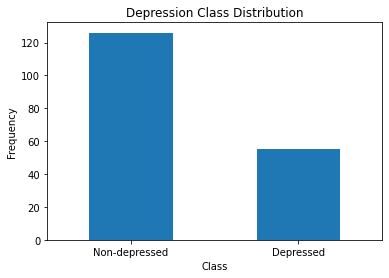

The ratio of negative to positive cases is 2.29.


In [2]:
df = pd.read_csv("../../data/clean_compiled_transcripts.csv")

count_classes = pd.value_counts(df.PHQ_Binary)
count_classes.plot(kind = 'bar', rot=0)
labels = ["Non-depressed", "Depressed"]

plt.title("Depression Class Distribution")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

print(f"The ratio of negative to positive cases is {round(count_classes[0] / count_classes[1], 2)}.")

Clearly, the dataset is highly imbalanced and is likely to result in poor performance. We should strive for 50:50 during training.

## Convert transcripts to padded sequences

In [3]:
RANDOM_STATE = 42 # lucky number

X = df.Transcript
y = df.PHQ_Binary

In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
vocab_size = len(tokenizer.word_index) + 1

tokenizer.word_index

{'i': 1,
 'um': 2,
 'it': 3,
 'uh': 4,
 'you': 5,
 'my': 6,
 'know': 7,
 'like': 8,
 'me': 9,
 'really': 10,
 'would': 11,
 'yeah': 12,
 'think': 13,
 'they': 14,
 'people': 15,
 'well': 16,
 'good': 17,
 'we': 18,
 'things': 19,
 'get': 20,
 'lot': 21,
 'time': 22,
 'go': 23,
 'she': 24,
 'he': 25,
 'pretty': 26,
 'going': 27,
 'one': 28,
 'probably': 29,
 'them': 30,
 'little': 31,
 'life': 32,
 'something': 33,
 'say': 34,
 'could': 35,
 'mm': 36,
 'feel': 37,
 'guess': 38,
 'much': 39,
 'years': 40,
 'mean': 41,
 'different': 42,
 'yes': 43,
 'kinda': 44,
 'myself': 45,
 'back': 46,
 'want': 47,
 'oh': 48,
 'see': 49,
 'right': 50,
 'got': 51,
 'sometimes': 52,
 'her': 53,
 'always': 54,
 'went': 55,
 'hard': 56,
 'ago': 57,
 'work': 58,
 'okay': 59,
 'kind': 60,
 'school': 61,
 'try': 62,
 'family': 63,
 'maybe': 64,
 'love': 65,
 'actually': 66,
 'make': 67,
 'day': 68,
 'friends': 69,
 'happy': 70,
 'way': 71,
 'thing': 72,
 'anything': 73,
 'last': 74,
 'job': 75,
 'two': 76,
 

In [5]:
maxlen = 1000

def prepare(X):
    X_seq = tokenizer.texts_to_sequences(X)
    X_mat = sequence.pad_sequences(X_seq, maxlen=maxlen)
    
    return X_mat

## Split the dataset 

In [6]:
X_train_val, X_test, y_train_val, y_test = train_test_split(prepare(X), y, test_size=0.2, random_state=RANDOM_STATE)

X_train_val.shape, X_test.shape

((144, 1000), (37, 1000))

### Undersampling
We will be using undersampling techniques instead of oversampling because we are not sure of the newly generated data points.

In [7]:
# the ratio of minority class to majority class will be 1 after resampling
us = RandomUnderSampler(sampling_strategy=1, random_state=RANDOM_STATE)

X_train_val, y_train_val = us.fit_sample(X_train_val, y_train_val)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=RANDOM_STATE)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((70, 1000), (18, 1000), (70,), (18,))

Now we have `X_train`, `X_val`, `X_test`, `y_train`, `y_val`, `y_test` ready to be used for model training, validation and testing. If we are using k-fold cross-validation techniques, we can use `X_train_val`, `y_train_val`.

# More preprocessing

## Evaluation metrics
Some considerations in evaluation metrics when deciding our model.
1. In our use case, it is more important to have high sensitivity as want to correctly identify as many depression cases out of all actual depression cases for early intervention. Predicting a non-depressed person as depressed is comparatively less severe, meaning we prioritize TPR (sensitivity) over FPR.
2. We will use `f1_score` (default: returns the score for positive class in the `binary` case) to prioritize the prediction for the positive class. Because we have evenly distributed the train set, using `macro` or `weighted` puts equal weight on both classes and removes the priority that we want.

Note:
* Sensitivity = true positive rate = recall = TP / (TP + FN)
* Specificity = true negative rate = TN / (TN + FP)
* Fall out = false positive rate = FP / (FP + TN)
* Miss rate = false negative rate = FN / (FN + TP)

Metrics can be found on this [website](https://scikit-learn.org/stable/modules/model_evaluation.html).

In [8]:
def evaluate_on_training_set(y_test, y_pred):
    # Calculate AUC
    print("AUC is: ", roc_auc_score(y_test, y_pred))

    # print out recall and precision
    print(classification_report(y_test, y_pred))

    # print out confusion matrix
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

    # # calculate points for ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')

## Run model

In [9]:
class Metrics(Callback):

    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(f" — val_f1: {_val_f1} — val_precision: {_val_precision} — val_recall: {_val_recall}")
        return

metrics = Metrics()

In [10]:
def train_NN(model, model_name):
    es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    checkpoint_filepath = f'{model_name}.h5'

    checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True)

    model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), callbacks=[es, checkpoint, metrics])
    loss, acc = model.evaluate(X_test, y_test)

    model = load_model(checkpoint_filepath)

    print('Test loss:', loss)
    print('Test accuracy:', acc)
    
    return model

# Model Implementation

## Naive Neural Networks

In [11]:
model_name = "customNN_embeddings_naive"

naive_model = Sequential()

naive_model.add(Embedding(vocab_size, 128, input_length=maxlen))
naive_model.add(Flatten())
naive_model.add(Dense(100))
naive_model.add(Dense(1, activation='sigmoid'))

print(naive_model.summary())
#plot_model(lstm_model, to_file=f'{model_name}.png', show_shapes=True)

train_NN(naive_model, model_name)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 128)         1009152   
_________________________________________________________________
flatten_1 (Flatten)          (None, 128000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               12800100  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 13,809,353
Trainable params: 13,809,353
Non-trainable params: 0
_________________________________________________________________
None


/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 70 samples, validate on 18 samples
Epoch 1/50
70/70 [==============================] - 1s 8ms/step - loss: 1.3878 - accuracy: 0.3857 - val_loss: 1.2792 - val_accuracy: 0.5000
 — val_f1: 0.6666666666666667 — val_precision: 0.5294117647058824 — val_recall: 0.9
Epoch 2/50
70/70 [==============================] - 0s 268us/step - loss: 0.5176 - accuracy: 0.8714 - val_loss: 5.3314 - val_accuracy: 0.4444
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
Epoch 3/50
70/70 [==============================] - 0s 257us/step - loss: 0.7171 - accuracy: 0.8286 - val_loss: 1.9029 - val_accuracy: 0.4444
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
Epoch 4/50
70/70 [==============================] - 0s 255us/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.3013 - val_accuracy: 0.5556
 — val_f1: 0.6363636363636365 — val_precision: 0.5833333333333334 — val_recall: 0.7
Epoch 5/50
70/70 [==============================] - 0s 255us/step - loss: 0.2765 - accuracy: 0.9143 - val_loss: 1.

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 — val_f1: 0.6 — val_precision: 0.6 — val_recall: 0.6
Epoch 7/50
70/70 [==============================] - 0s 272us/step - loss: 7.8716e-05 - accuracy: 1.0000 - val_loss: 0.8821 - val_accuracy: 0.5000
 — val_f1: 0.30769230769230765 — val_precision: 0.6666666666666666 — val_recall: 0.2
Epoch 8/50
70/70 [==============================] - 0s 298us/step - loss: 7.4043e-06 - accuracy: 1.0000 - val_loss: 1.5064 - val_accuracy: 0.4444
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
Epoch 9/50
70/70 [==============================] - 0s 284us/step - loss: 5.0395e-06 - accuracy: 1.0000 - val_loss: 2.0861 - val_accuracy: 0.4444
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
Epoch 10/50
70/70 [==============================] - 0s 262us/step - loss: 3.9569e-06 - accuracy: 1.0000 - val_loss: 2.5209 - val_accuracy: 0.5000
 — val_f1: 0.18181818181818182 — val_precision: 1.0 — val_recall: 0.1
Epoch 11/50
70/70 [==============================] - 0s 279us/step - loss: 3.8797e-06 - accuracy: 

 — val_f1: 0.18181818181818182 — val_precision: 1.0 — val_recall: 0.1
Epoch 45/50
70/70 [==============================] - 0s 244us/step - loss: 2.6520e-06 - accuracy: 1.0000 - val_loss: 3.7237 - val_accuracy: 0.5000
 — val_f1: 0.18181818181818182 — val_precision: 1.0 — val_recall: 0.1
Epoch 46/50
70/70 [==============================] - 0s 260us/step - loss: 2.6093e-06 - accuracy: 1.0000 - val_loss: 3.7235 - val_accuracy: 0.5000
 — val_f1: 0.18181818181818182 — val_precision: 1.0 — val_recall: 0.1
Epoch 47/50
70/70 [==============================] - 0s 249us/step - loss: 2.5813e-06 - accuracy: 1.0000 - val_loss: 3.7233 - val_accuracy: 0.5000
 — val_f1: 0.18181818181818182 — val_precision: 1.0 — val_recall: 0.1
Epoch 48/50
70/70 [==============================] - 0s 257us/step - loss: 2.5423e-06 - accuracy: 1.0000 - val_loss: 3.7230 - val_accuracy: 0.5000
 — val_f1: 0.18181818181818182 — val_precision: 1.0 — val_recall: 0.1
Epoch 49/50
70/70 [==============================] - 0s 242us/

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0] 

AUC is:  0.5979020979020979
              precision    recall  f1-score   support

           0       0.75      0.92      0.83        26
           1       0.60      0.27      0.37        11

    accuracy                           0.73        37
   macro avg       0.68      0.60      0.60        37
weighted avg       0.71      0.73      0.69        37

Confusion Matrix: 
 [[24  2]
 [ 8  3]]


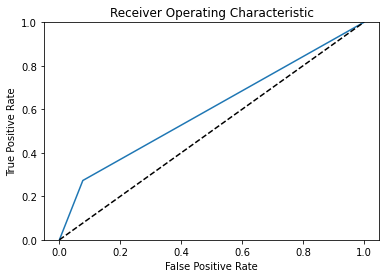

In [12]:
predictions = naive_model.predict(X_test)
y_pred = np.where(predictions > 0.5, 1, 0).flatten()

print(y_pred)
print(y_test.to_numpy(), '\n')

evaluate_on_training_set(y_test, y_pred)

## Long Short Term Memory

In [13]:
model_name = "customNN_embeddings_lstm"

lstm_model = Sequential()

lstm_model.add(Embedding(vocab_size, 128, input_length=maxlen, dropout=0.2))
lstm_model.add(LSTM(50, dropout_U = 0.2, dropout_W = 0.2))
lstm_model.add(Dense(1, bias_initializer=Constant(0.01), activation="sigmoid"))

print(lstm_model.summary())
#plot_model(lstm_model, to_file=f'{model_name}.png', show_shapes=True)

train_NN(lstm_model, model_name)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(50, dropout=0.2, recurrent_dropout=0.2)`
  


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 128)         1009152   
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 1,045,003
Trainable params: 1,045,003
Non-trainable params: 0
_________________________________________________________________
None


/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 70 samples, validate on 18 samples
Epoch 1/50
70/70 [==============================] - 4s 64ms/step - loss: 0.6947 - accuracy: 0.4286 - val_loss: 0.6924 - val_accuracy: 0.4444
 — val_f1: 0.16666666666666669 — val_precision: 0.5 — val_recall: 0.1
Epoch 2/50
70/70 [==============================] - 4s 56ms/step - loss: 0.6885 - accuracy: 0.6429 - val_loss: 0.6940 - val_accuracy: 0.5000
 — val_f1: 0.18181818181818182 — val_precision: 1.0 — val_recall: 0.1
Epoch 3/50
70/70 [==============================] - 4s 55ms/step - loss: 0.6824 - accuracy: 0.8000 - val_loss: 0.6948 - val_accuracy: 0.4444
 — val_f1: 0.4444444444444445 — val_precision: 0.5 — val_recall: 0.4
Epoch 4/50
70/70 [==============================] - 4s 55ms/step - loss: 0.6741 - accuracy: 0.8286 - val_loss: 0.6956 - val_accuracy: 0.5000
 — val_f1: 0.5714285714285713 — val_precision: 0.5454545454545454 — val_recall: 0.6
Epoch 5/50
70/70 [==============================] - 4s 55ms/step - loss: 0.6646 - accuracy: 0.8714 

70/70 [==============================] - 4s 55ms/step - loss: 0.0120 - accuracy: 1.0000 - val_loss: 1.2099 - val_accuracy: 0.5000
 — val_f1: 0.5263157894736842 — val_precision: 0.5555555555555556 — val_recall: 0.5
Epoch 40/50
70/70 [==============================] - 4s 55ms/step - loss: 0.0126 - accuracy: 1.0000 - val_loss: 1.2290 - val_accuracy: 0.5000
 — val_f1: 0.5263157894736842 — val_precision: 0.5555555555555556 — val_recall: 0.5
Epoch 41/50
70/70 [==============================] - 4s 56ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 1.2336 - val_accuracy: 0.5000
 — val_f1: 0.5263157894736842 — val_precision: 0.5555555555555556 — val_recall: 0.5
Epoch 42/50
70/70 [==============================] - 4s 55ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 1.2429 - val_accuracy: 0.5000
 — val_f1: 0.5263157894736842 — val_precision: 0.5555555555555556 — val_recall: 0.5
Epoch 43/50
70/70 [==============================] - 4s 55ms/step - loss: 0.0081 - accuracy: 1.0000 - val_lo

[0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 1 0 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0] 

AUC is:  0.7412587412587412
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        26
           1       0.64      0.64      0.64        11

    accuracy                           0.78        37
   macro avg       0.74      0.74      0.74        37
weighted avg       0.78      0.78      0.78        37

Confusion Matrix: 
 [[22  4]
 [ 4  7]]


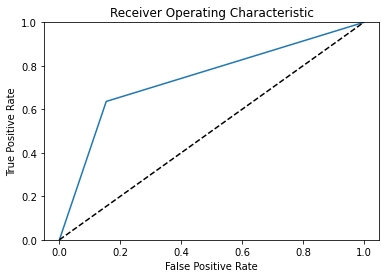

In [14]:
predictions = lstm_model.predict(X_test)
y_pred = np.where(predictions > 0.5, 1, 0).flatten()

print(y_pred)
print(y_test.to_numpy(), '\n')

evaluate_on_training_set(y_test, y_pred)